In [1]:
from DRecPy.Recommender import CDAE
from DRecPy.Dataset import get_train_dataset
from DRecPy.Dataset import get_test_dataset
from DRecPy.Evaluation import ranking_evaluation
from DRecPy.Evaluation import predictive_evaluation
import time
import os
import pandas as pd
from DRecPy.Dataset import InteractionDataset

In [2]:
# Just choose the name of the dataset directory
dataset  = 'ml-20m'
DATA_DIR = '/Users/tomas/Documents/FEUP/Tese/data/' + dataset
PARSE_DATA_DIR = os.path.join(DATA_DIR, 'processed_70_10_20')

In [3]:
ratings_train = pd.read_csv(os.path.join(PARSE_DATA_DIR, 'ratings.csv'), header=0)

In [4]:
ratings_train.head()

,userId,movieId,rating,timestamp
0,1,1079,4.0,1094785665
1,1,2959,4.0,1094785698
2,1,3996,4.0,1094785727
3,1,151,4.0,1094785734
4,1,1374,4.0,1094785746


In [5]:
# load dataset out of memory
ds_out_of_memory = InteractionDataset(os.path.join(PARSE_DATA_DIR, 'ratings.csv'), columns=['user', 'item', 'interaction', 'timestamp'],has_header=True ,in_memory=False)
parsed =  ds_out_of_memory.select('interaction > 3.5')

[DatabaseInteractionDataset] Trying to load data from file, using auxiliary database...


Importing dataset: 100%|█████████▉| 6866694/6866695 [00:35<00:00, 195691.02it/s]


[DatabaseInteractionDataset] Done!


In [6]:
parsed.assign_internal_ids()

[CDAE] Max. interaction value: 5.0
[CDAE] Min. interaction value: 4.0
[CDAE] Interaction threshold value: 0
[CDAE] Number of unique users: 129757
[CDAE] Number of unique items: 11491
[CDAE] Number of training points: 6866694
[CDAE] Sparsity level: approx. 99.5395%
[CDAE] Creating auxiliary structures...


Fitting model... Epoch 50 Avg. Loss: 0.2912: 100%|██████████| 50/50 [08:25<00:00, 10.10s/it]
No handles with labels found to put in legend.


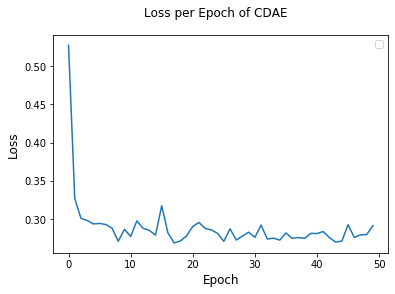

[CDAE] Model fitted.
Training took 539.8446600437164


In [14]:
start_train = time.time()
cdae = CDAE(min_interaction=0, seed=10,hidden_factors=200)
cdae.fit(parsed, epochs=50)
print("Training took", time.time() - start_train)

In [15]:
ds_train

NameError: name 'ds_train' is not defined

In [16]:
data = cdae.V.numpy()
df=pd.DataFrame(data=data[0:,0:],
                index=[i for i in range(data.shape[0])],
                columns=['f'+str(i) for i in range(data.shape[1])])

In [17]:
df.shape

(129757, 200)

In [18]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199
0,-1.903606e-32,6.126373e-32,-1.041586e-32,1.263656e-32,-2.556891e-32,1.446864e-32,-9.646448e-33,-5.381662e-32,6.522116e-32,7.285015e-33,...,-4.920046e-32,6.060555e-32,2.235629e-32,-4.628364e-32,2.501638e-32,2.035116e-32,-6.307185e-33,-5.740002e-32,-4.941461e-33,5.526963e-33
1,1.900094e-32,-1.379075e-32,1.011266e-33,2.059139e-32,1.075434e-32,-2.070336e-32,-1.327671e-32,1.270083e-32,4.228601e-32,8.307336e-34,...,6.549046e-32,-1.636893e-32,-7.016262e-32,5.906431e-32,3.564026e-32,-1.236979e-32,4.464314e-32,5.423416e-32,1.168587e-32,3.916058e-32
2,2.444368e-32,3.962619e-32,9.056878e-33,3.192449e-33,3.738563e-32,-1.772403e-32,-1.301265e-32,-9.639824e-33,-1.116018e-32,-9.527382e-33,...,1.384151e-32,1.820109e-32,1.231361e-32,-5.183509e-32,-6.564572e-32,1.134003e-32,-1.574783e-32,1.704961e-32,2.476006e-32,-1.758963e-32
3,4.466596e-33,-2.635078e-32,2.006423e-32,-1.423771e-32,-6.095561e-33,6.230152e-32,2.212825e-32,1.006452e-32,-2.705935e-33,-1.075054e-32,...,3.068422e-33,-2.434828e-32,1.528099e-32,-1.850326e-32,-2.335936e-32,-2.447797e-32,-6.060576e-32,-1.452331e-32,1.337930e-32,1.191742e-32
4,-5.134871e-32,-5.446336e-32,-2.477626e-32,-4.326088e-32,3.837729e-32,-5.030845e-32,1.458891e-32,-1.001956e-33,-5.085300e-33,-2.587311e-32,...,-1.141153e-32,-5.578014e-32,-1.985515e-32,-6.105519e-32,-1.097290e-32,-6.064440e-33,-1.576612e-32,1.427874e-32,-4.925032e-32,-1.422201e-33


In [10]:
unique_uid = pd.DataFrame(data=ratings_train.userId.unique(), columns=['uid'])

In [11]:
# Merge two Dataframes on index of both the dataframes
final_cdae = unique_uid.merge(df, left_index=True, right_index=True)

In [14]:
final_cdae.shape

(129757, 201)

In [21]:
final_cdae.head()

,uid,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199
0,1,-1.903606e-32,6.126373e-32,-1.041586e-32,1.263656e-32,-2.556891e-32,1.446864e-32,-9.646448e-33,-5.381662e-32,6.522116e-32,...,-4.920046e-32,6.060555e-32,2.235629e-32,-4.628364e-32,2.501638e-32,2.035116e-32,-6.307185e-33,-5.740002e-32,-4.941461e-33,5.526963e-33
1,2,1.900094e-32,-1.379075e-32,1.011266e-33,2.059139e-32,1.075434e-32,-2.070336e-32,-1.327671e-32,1.270083e-32,4.228601e-32,...,6.549046e-32,-1.636893e-32,-7.016262e-32,5.906431e-32,3.564026e-32,-1.236979e-32,4.464314e-32,5.423416e-32,1.168587e-32,3.916058e-32
2,3,2.444368e-32,3.962619e-32,9.056878e-33,3.192449e-33,3.738563e-32,-1.772403e-32,-1.301265e-32,-9.639824e-33,-1.116018e-32,...,1.384151e-32,1.820109e-32,1.231361e-32,-5.183509e-32,-6.564572e-32,1.134003e-32,-1.574783e-32,1.704961e-32,2.476006e-32,-1.758963e-32
3,4,4.466596e-33,-2.635078e-32,2.006423e-32,-1.423771e-32,-6.095561e-33,6.230152e-32,2.212825e-32,1.006452e-32,-2.705935e-33,...,3.068422e-33,-2.434828e-32,1.528099e-32,-1.850326e-32,-2.335936e-32,-2.447797e-32,-6.060576e-32,-1.452331e-32,1.337930e-32,1.191742e-32
4,5,-5.134871e-32,-5.446336e-32,-2.477626e-32,-4.326088e-32,3.837729e-32,-5.030845e-32,1.458891e-32,-1.001956e-33,-5.085300e-33,...,-1.141153e-32,-5.578014e-32,-1.985515e-32,-6.105519e-32,-1.097290e-32,-6.064440e-33,-1.576612e-32,1.427874e-32,-4.925032e-32,-1.422201e-33


In [ ]:
final_cdae.to_csv(os.path.join(PARSE_DATA_DIR, 'cdae_embeddings.csv'), index=False)

In [ ]:
print(ranking_evaluation(cdae, ds_test, n_test_users=100, seed=10))
print(predictive_evaluation(cdae, ds_test, skip_errors=True))